# Simple 4 layer model

**For this notebook, a simple 4 layer model is used to create synthetic data. The data are Gamma Ray, Induction, Neutron-Density and Photoelectric effect. The orientation of the layers is horizontal.**

In [1]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
import seaborn as sns
import gempy as gp

import sys
sys.path.append("../")
import bayseg

C:\Users\Public\Anaconda3\lib\site-packages\gempy\posterior_analysis.py:24: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")


In [2]:
# data import
data = pd.read_csv("../data/synthetic_data.csv")                         # load the data from excel sheet
data.head()        

,X,Y,Z,Well Name,GR,NEUDEN,IND,PE
0,50,50,10,BH1,50.01,3.91,10.34,0.80
1,50,50,20,BH1,51.72,3.78,11.91,0.35
2,50,50,30,BH1,53.27,3.36,10.39,0.53
3,50,50,40,BH1,50.66,3.45,11.22,0.28
4,50,50,50,BH1,52.84,3.72,11.57,0.09


In [3]:
# data setting
feature_names =  ['GR', 'NEUDEN', 'IND','PE']    # define data that are considered by headers from excel sheet(Gamma Ray,Induction, Neutron-density, delta Neutron-density, Photoelectric effect)
feature_vectors = data[feature_names]                             # create matrix including the data + headers
boreholes = ['BH1','BH2','BH3','BH4','BH5']
coords = np.array(data["Z"].values).T                       # creating vector with depth information (z in [m])

In [4]:
# normalize data
#def normalize_feature_vectors(feature_vectors):      # function to normalize data (x - mean / sigma)
    #return (feature_vectors - np.mean(feature_vectors, axis=0).T) / np.std(feature_vectors, axis=0)
    
feature_vectors_norm = bayseg.normalize_feature_vectors(feature_vectors.values) # normalize data (.values just takes the values not the header and indicies)

In [5]:
# Bayesian information criteria (executing BIC several times and test 2 - 25 layers)
nf, nft = bayseg.test_bic(feature_vectors_norm)


The optimal number of layers is:  4


In [6]:
# perform BaySeg clustering
clf = bayseg.BaySeg(feature_vectors_norm, nf, data, feature_names, boreholes, gp_resolution = 30)

clf.fit(10, # number of iterations
        beta_jump_length=2, 
        mu_jump_length=0.0005, 
        cov_volume_jump_length=0.00005, 
        theta_jump_length=0.0000005, verbose=False)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

mus: [[-0.41026363  0.55270792 -0.33588836 -0.45168286]
 [ 0.57031458  1.25733165  1.27179166  1.32939986]
 [-1.39593004 -1.37813377  0.46114036  0.4497371 ]
 [ 1.23587909 -0.43190579 -1.39704366 -1.3274541 ]]
covs: [[[ 0.00885261 -0.00015128  0.00350251  0.00148579]
  [-0.00015128  0.00566251 -0.00183831  0.00035402]
  [ 0.00350251 -0.00183831  0.02602906 -0.00080213]
  [ 0.00148579  0.00035402 -0.00080213  0.02131575]]

 [[ 0.00698519 -0.00209976  0.00326636  0.00231096]
  [-0.00209976  0.00752743 -0.00348628 -0.0027883 ]
  [ 0.00326636 -0.00348628  0.0197551   0.00188859]
  [ 0.00231096 -0.0027883   0.00188859  0.01430383]]

 [[ 0.00698363  0.00088856 -0.00716896 -0.00132242]
  [ 0.00088856  0.00489619 -0.00290896  0.00035317]
  [-0.00716896 -0.00290896  0.02795192  0.00646743]
  [-0.00132242  0.00035317  0.00646743  0.01668519]]

 [[ 0.00758982 -0.00127566 -0.00116982 -0.00290261]
  [-0.00127566  0.00975365  0.0037793  -0.00305459]
  [-0.00116982  0.0037793   0.03161149 -0.00249347

TypeError: object of type 'numpy.int64' has no len()

In [7]:
lt = np.tile(clf.labels[-1],(clf.n_labels, 1)).T
print(lt.shape)

(100, 4)


In [8]:
ge = np.arange(clf.n_labels)
print(ge)

[0 1 2 3]


In [9]:
ge = np.tile(ge,(len(clf.labels[-1]),1)).astype(float)
print(ge.shape)

(100, 4)


In [10]:
top = [np.not_equal(np.arange(clf.n_labels), lt[1, :])*clf.betas[-1]]

In [11]:
mid = (np.not_equal(ge[1:-1, :], lt[:-2, :]).astype(float) + np.not_equal(ge[1:-1, :], lt[2:, :]).astype(float)) * clf.betas[-1]
mid.shape

(98, 4)

In [12]:
bot = np.expand_dims(np.not_equal(np.arange(clf.n_labels), lt[-2, :]) * clf.betas[-1], axis=0)
bot.shape

(1, 4)

In [14]:
bla = np.concatenate((top, mid, bot))
bla.shape

(100, 4)

In [16]:
#clf.storage_gibbs_e

In [17]:
#np.shape(clf.storage_gibbs_e)

In [18]:
#clf.storage_like_e

In [19]:
# data convertion to gempy
bayseg.prepare_gempy_input(data,clf.labels[-1]+1)

In [20]:
# data convertion to gempy
formation = clf.labels[-1]+1            # vector with final labeling including all wells 
                                        # labels + 1 because gempy doesn't like the zero as formation name

gempy = pd.DataFrame({'X': data.X ,'Y' : data.Y ,'Z' : data.Z ,'formation' : formation, 'borehole': data['Well Name']})

for k in range(0,len(gempy)-1):
    if gempy.loc[k,'formation'] == gempy.loc[k+1,'formation']:
        gempy = gempy.drop(k)
        
gempy.index = range(len(gempy)) 

for k in range(0,1 + len(set(list(gempy['formation'])))):
    gempy['formation'] = gempy['formation'].replace(to_replace = k, value = 'Layer%d' %(k))
    
for k in range(0,1 + len(set(list(gempy['formation'])))):
    gempy['formation'] = gempy['formation'].replace(to_replace = k, value = 'Layer%d' %(k))

gempy.to_csv('../data/Gempy_Simple_4_layer_90degrees.csv',index=False)

# Gempy

In [12]:
# Importing the data from CSV-files and setting extent and resolution
geo_data = gp.create_data([0,200,0,200,0,200],[50,50,50], 
                          #path_o = "../data/Gempy_Simple_4_layer_90degrees_orientation.csv", # importing orientation (foliation) data
                          path_i = "../data/Gempy_Simple_4_layer_90degrees.csv") # importing point-positional interface data

In [55]:
self.series

NameError: name 'self' is not defined

In [53]:
gp.set_orientation_from_interfaces(geo_data,a)

[0. 0. 1.]


In [54]:
geo_data.orientations

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,X_std,Y_std,Z_std,dip_std,azimuth_std,order_series,isFault,formation number,annotations
0,116.667,116.667,50.0,1.000000e-07,1.000000e-07,1.0,0.0,0.0,1.0,[Layer1],Default serie,NaN,NaN,NaN,NaN,NaN,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},0}$"
1,83.3333,116.667,50.0,1.000000e-07,1.000000e-07,1.0,0.0,0.0,1.0,[Layer1],Default serie,NaN,NaN,NaN,NaN,NaN,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},1}$"
2,112.5,87.5,50.0,1.000000e-07,1.000000e-07,1.0,0.0,0.0,1.0,[Layer1],Default serie,NaN,NaN,NaN,NaN,NaN,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},2}$"
3,100,100,50.0,1.000000e-07,1.000000e-07,1.0,0.0,0.0,1.0,[Layer1],Default serie,NaN,NaN,NaN,NaN,NaN,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},3}$"


In [22]:
## force formations to be strings
#geo_data.interfaces['formation'] = geo_data.interfaces['formation'].astype(str)
#geo_data.orientations['formation'] = geo_data.orientations['formation'].astype(str)

In [23]:
gp.plot_data_3D(geo_data)

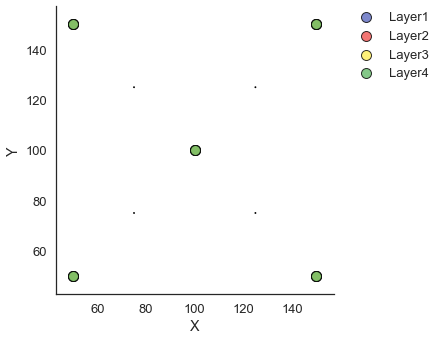

In [24]:
gp.plot_data(geo_data, direction='z')

In [25]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"Unknown": ('Layer4','Layer2', 'Layer3', 'Layer1')},
                       order_series = ["Strat_Series"],
                       order_formations=['Layer4','Layer2', 'Layer3', 'Layer1'], verbose=0) 

In [26]:
#gp.get_data(geo_data, verbosity=1)

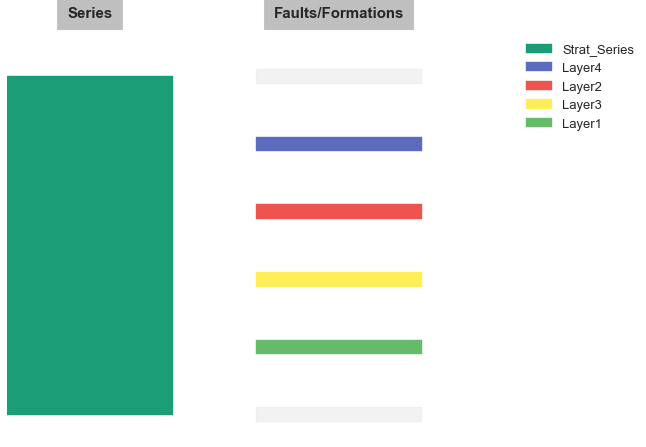

In [27]:
gp.get_sequential_pile(geo_data)

In [28]:
# u_grade depends on number of series (one series [1], two series [1,1]...) 
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True,
                                  dtype='float64', theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0


In [17]:
#interp_data.geo_data_res.get_formation_number()

In [18]:
gp.get_kriging_parameters(interp_data)

range 1.1547005383792515 346.41016151377545
Number of drift equations [3]
Covariance at 0 0.031746031746031744
orientations nugget effect 0.01
scalar nugget effect 1e-06


In [19]:
#interp_data.update_interpolator(geo_data)

In [29]:
lith_block, fault_block = gp.compute_model(interp_data)

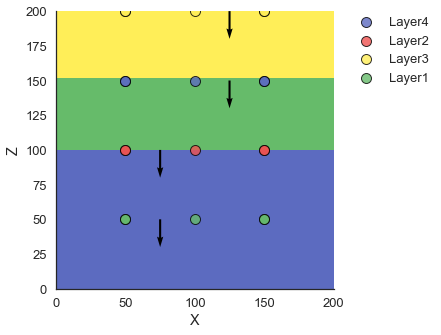

In [30]:
gp.plot_section(geo_data, lith_block[0], cell_number=10,  direction='y', plot_data=True)

In [22]:
#gp.plot_scalar_field(geo_data, lith_block[1], 15)
#plt.colorbar()

In [23]:
#interp_data.potential_at_interfaces

In [24]:
ver, sim = gp.get_surfaces(interp_data, lith_block[1], original_scale=True)

Potential field of the surface is outside the block. Probably is due to float errors


In [25]:
gp.plot_surfaces_3D(geo_data, ver, sim, alpha=1)